
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.18.2?urlpath=lab/tree/light_curve.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[light_curve.ipynb](../_static/notebooks/light_curve.ipynb) |
[light_curve.py](../_static/notebooks/light_curve.py)
</div>


# Light curve estimation

## Prerequisites

- Knowledge of the high level interface to perform data reduction, see [first gammapy analysis with the high level interface tutorial](analysis_1.ipynb)

## Context

This tutorial presents how light curve extraction is performed in gammapy, i.e. how to measure the flux of a source
in different time bins.

Cherenkov telescopes usually work with observing runs and distribute data according to this basic time interval. A typical use case is to look for variability of a source on various time binnings: observation run-wise binning, nightly, weekly etc.

**Objective: The Crab nebula is not known to be variable at TeV energies, so we expect constant brightness within statistical and systematic errors. Compute per-observation and nightly fluxes of the four Crab nebula observations from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/) to check it.**

## Proposed approach

We will demonstrate how to compute a `~gammapy.estimators.LightCurve` from 3D reduced datasets (`~gammapy.datasets.MapDataset`) as well as 1D ON-OFF spectral datasets (`~gammapy.datasets.SpectrumDatasetOnOff`). 

The data reduction will be performed with the high level interface for the data reduction. Then we will use the `~gammapy.estimators.LightCurveEstimator` class, which  is able to extract a light curve independently of the dataset type. 



## Setup

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
import logging

from astropy.time import Time

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.estimators import LightCurveEstimator
from gammapy.analysis import Analysis, AnalysisConfig

## Analysis configuration 
For the 1D and 3D extraction, we will use the same CrabNebula configuration than in the notebook analysis_1.ipynb using the high level interface of Gammapy.

From the high level interface, the data reduction for those observations is performed as followed

### Building the 3D analysis configuration


In [3]:
conf_3d = AnalysisConfig()

#### Definition of the data selection

Here we use the Crab runs from the HESS DL3 data release 1

In [4]:
conf_3d.observations.obs_ids = [23523, 23526, 23559, 23592]

#### Definition of the dataset geometry

In [5]:
# We want a 3D analysis
conf_3d.datasets.type = "3d"

# We want to extract the data by observation and therefore to not stack them
conf_3d.datasets.stack = False

# Here is the WCS geometry of the Maps
conf_3d.datasets.geom.wcs.skydir = dict(
    frame="icrs", lon=83.63308 * u.deg, lat=22.01450 * u.deg
)
conf_3d.datasets.geom.wcs.binsize = 0.02 * u.deg
conf_3d.datasets.geom.wcs.fov = dict(width=1 * u.deg, height=1 * u.deg)

# We define a value for the IRF Maps binsize
conf_3d.datasets.geom.wcs.binsize_irf = 0.2 * u.deg

# Define energy binning for the Maps
conf_3d.datasets.geom.axes.energy = dict(
    min=0.7 * u.TeV, max=10 * u.TeV, nbins=5
)
conf_3d.datasets.geom.axes.energy_true = dict(
    min=0.3 * u.TeV, max=20 * u.TeV, nbins=20
)

### Run the 3D data reduction

In [6]:
analysis_3d = Analysis(conf_3d)
analysis_3d.get_observations()
analysis_3d.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 4
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 23523
Processing observation 23526
Processing observation 23559
Processing observation 23592


### Define the model to be used

Here we don't try to fit the model parameters to the whole dataset, but we use predefined values instead. 

In [7]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)
# Now we freeze these parameters that we don't want the light curve estimator to change
sky_model.parameters["index"].frozen = True
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True

We assign them the model to be fitted to each dataset

In [8]:
models = Models([sky_model])
analysis_3d.set_models(models)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index        (frozen)   :   2.702              
    amplitude               :   4.71e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : 1Evh9PiE-bkg
  Datasets names            : ['1Evh9PiE']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : r8NJTAfB-bkg
  Datasets names            : ['r8NJTAfB']
  Spect

## Light Curve estimation: by observation

We can now create the light curve estimator.

We pass it the list of datasets and the name of the model component for which we want to build the light curve. 
We can optionally ask for parameters reoptimization during fit, that is most of the time to fit background normalization in each time bin. 

If we don't set any time interval, the `~gammapy.time.LightCurveEstimator` is determines the flux of each dataset and places it at the corresponding time in the light curve. 
Here one dataset equals to one observing run.

In [9]:
lc_maker_3d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV, source="crab", reoptimize=False
)
lc_3d = lc_maker_3d.run(analysis_3d.datasets)

The LightCurve object contains a table which we can explore.

In [10]:
lc_3d.table["time_min", "time_max", "e_min", "e_max", "flux", "flux_err"]

time_min,time_max,e_min [1],e_max [1],flux [1],flux_err [1]
,,TeV,TeV,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64
53343.92234009259,53343.94186555555,1.191457161449437,10.000000000000002,2.0044854222687593e-11,2.0855480821587682e-12
53343.95421509259,53343.97369425926,1.191457161449437,10.000000000000002,2.034368084890059e-11,2.112697965713362e-12
53345.96198129629,53345.98149518518,1.191457161449437,10.000000000000002,2.1489523572686956e-11,2.7480983271873764e-12
53347.91319657407,53347.932710462956,1.191457161449437,10.000000000000002,2.475608406609803e-11,2.8758307941587e-12


## Running the light curve extraction in 1D

### Building the 1D analysis configuration


In [11]:
conf_1d = AnalysisConfig()

#### Definition of the data selection

Here we use the Crab runs from the HESS DL3 data release 1

In [12]:
conf_1d.observations.obs_ids = [23523, 23526, 23559, 23592]

#### Definition of the dataset geometry

In [13]:
# We want a 1D analysis
conf_1d.datasets.type = "1d"

# We want to extract the data by observation and therefore to not stack them
conf_1d.datasets.stack = False

# Here we define the ON region and make sure that PSF leakage is corrected
conf_1d.datasets.on_region = dict(
    frame="icrs",
    lon=83.63308 * u.deg,
    lat=22.01450 * u.deg,
    radius=0.1 * u.deg,
)
conf_1d.datasets.containment_correction = True

# Finally we define the energy binning for the spectra
conf_1d.datasets.geom.axes.energy = dict(
    min=0.7 * u.TeV, max=10 * u.TeV, nbins=5
)
conf_1d.datasets.geom.axes.energy_true = dict(
    min=0.3 * u.TeV, max=20 * u.TeV, nbins=20
)

### Run the 1D data reduction

In [14]:
analysis_1d = Analysis(conf_1d)
analysis_1d.get_observations()
analysis_1d.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 4
Reducing spectrum datasets.
No background maker set for 1d analysis. Check configuration.
Processing observation 23523
Processing observation 23526
Processing observation 23559
Processing observation 23592


### Define the model to be used

Here we don't try to fit the model parameters to the whole dataset, but we use predefined values instead. 

In [15]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)
# Now we freeze these parameters that we don't want the light curve estimator to change
sky_model.parameters["index"].frozen = True
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True

We assign the model to be fitted to each dataset. We can use the same `~gammapy.modeling.models.SkyModel` as before.

In [16]:
models = Models([sky_model])
analysis_1d.set_models(models)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index        (frozen)   :   2.702              
    amplitude               :   4.71e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : 2REewNGQ-bkg
  Datasets names            : ['2REewNGQ']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : p0VW5zbp-bkg
  Datasets names            : ['p0VW5zbp']
  Spect

### Extracting the light curve

In [17]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV, source="crab", reoptimize=False
)
lc_1d = lc_maker_1d.run(analysis_1d.datasets)

In [18]:
lc_1d.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
53343.92234009259,53343.94186555555,81.0,3.4517490659800822,1.191457161449437,10.000000000000002,1.657384679989307e-12,1.9997707038808555e-11,4.6024352468667415e-11,1.9747028462498433e-11,1.1077029613079503,-344.46779270983944,True,0.1230780763538574,344.46779270983944,0.1276819368258287,0.11855915290736221,1.3724291644205362,0.20000000000000004 .. 5.000000000000001,-199.9175888645825 .. -19.386516533883032,18.559843552946223,1.8358899180505848e-12,2.2746430714811222e-12,2.0398771819143742e-13,2.1161808600649101e-13,1.9649812370117182e-13,2.215151930625708e-11,2.74454363615987e-11,2.4612793138245506e-12,2.553345966790584e-12,2.370911206610737e-12
53343.95421509259,53343.97369425926,71.0,3.4517490659800822,1.191457161449437,10.000000000000002,1.657384679989307e-12,1.9997707038808555e-11,4.6024352468667415e-11,1.9747028462498433e-11,0.9396535421692533,-290.3067791773886,True,0.11151633206300965,290.3067791773886,0.11597465580179304,0.10714526139803303,1.1806767172586476,0.20000000000000004 .. 5.000000000000001,-182.3807552652466 .. 85.90879132960387,17.038391331853738,1.5573673852890066e-12,1.956835503204549e-12,1.8482546032983253e-13,1.9221461779292478e-13,1.7758091477454962e-13,1.879091625427947e-11,2.3610827099280636e-11,2.23007093863856e-12,2.3192271906509163e-12,2.1426595480344276e-12
53345.96198129629,53345.98149518518,51.0,3.4517490659800822,1.191457161449437,10.000000000000002,1.657384679989307e-12,1.9997707038808555e-11,4.6024352468667415e-11,1.9747028462498433e-11,1.0777854311309056,-194.3667669045744,True,0.15092011323410282,194.3667669045744,0.15805342459671168,0.14395123658334327,1.4084516476051048,0.20000000000000004 .. 5.000000000000001,-105.63485559830283 .. 20.299781619251345,13.941548224805393,1.7863050618720333e-12,2.3343461832463985e-12,2.5013268357645345e-13,2.61955324546435e-13,2.385825741787494e-13,2.1553237302451825e-11,2.816580342713411e-11,3.018056210719402e-12,3.1607060815654585e-12,2.8786946570679194e-12
53347.91319657407,53347.932710462956,59.0,3.4517490659800822,1.191457161449437,10.000000000000002,1.657384679989307e-12,1.9997707038808555e-11,4.6024352468667415e-11,1.9747028462498433e-11,1.2432090866786893,-226.7160500099006,True,0.1618519998284809,226.7160500099006,0.168957789152842,0.1548985351472951,1.5956091603832296,0.20000000000000004 .. 5.000000000000001,-110.13036820572225 .. -34.366035108238776,15.057093013257925,2.060475694284758e-12,2.6445381776697655e-12,2.6825102494135613e-13,2.800280513067838e-13,2.567264591059121e-13,2.486133110338518e-11,3.1908524537783117e-11,3.2366688762152535e-12,3.37876836940332e-12,3.0976155266161975e-12


### Compare results

Finally we compare the result for the 1D and 3D lightcurve in a single figure:

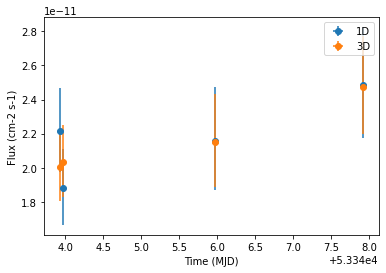

In [19]:
ax = lc_1d.plot(marker="o", label="1D")
lc_3d.plot(ax=ax, marker="o", label="3D")
plt.legend()

## Night-wise LC estimation

Here we want to extract a night curve per night. We define the time intervals that cover the three nights.

In [20]:
time_intervals = [
    Time([53343.5, 53344.5], format="mjd", scale="utc"),
    Time([53345.5, 53346.5], format="mjd", scale="utc"),
    Time([53347.5, 53348.5], format="mjd", scale="utc"),
]

To compute the LC on the time intervals defined above, we pass the `LightCurveEstimator` the list of time intervals. 

Internally, datasets are grouped per time interval and a flux extraction is performed for each group.

No handles with labels found to put in legend.


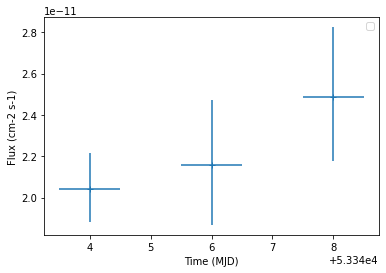

In [21]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV,
    time_intervals=time_intervals,
    source="crab",
    reoptimize=False,
)

nightwise_lc = lc_maker_1d.run(analysis_1d.datasets)

nightwise_lc.plot()

## What next?

When sources are bight enough to look for variability at small time scales, the per-observation time binning is no longer relevant. One can easily extend the light curve estimation approach presented above to any time binning. This is demonstrated in the [following tutorial](light_curve_flare.ipynb) which shows the extraction of the lightcurve of an AGN flare.